# Dark Vessel Detection Project

## A simple Vessel Detector CNN implemented in Keras

Load data:

In [1]:
from os import listdir
from os.path import isfile, join
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt # for any plotting later on...

#Dataset directories:
vessel_dir = 'Chips/vessels'
nonvessel_dir = 'Chips/nonvessels'

#Get names of vessel data and nonvessel data files:
vessel_files = [f for f in listdir(vessel_dir) if isfile(join(vessel_dir, f))]
nonvessel_files = [f for f in listdir(nonvessel_dir) if isfile(join(nonvessel_dir, f))]

#Specify dimensionality of .tiffs:
num_rows, num_cols = 144, 144

vessels = np.zeros((num_cols, num_cols, len(vessel_files)))
nonvessels = np.zeros((num_cols, num_cols, len(nonvessel_files)))

#Load datapoints:
for i in range(len(vessel_files)):
    vessels[:,:,i] = np.array(Image.open(vessel_dir +"/"+ vessel_files[i]))
 
for i in range(len(nonvessel_files)):
    nonvessels[:,:,i] = np.array(Image.open(nonvessel_dir +"/"+ nonvessel_files[i]))

Visualization -- Visualize some datapoints:

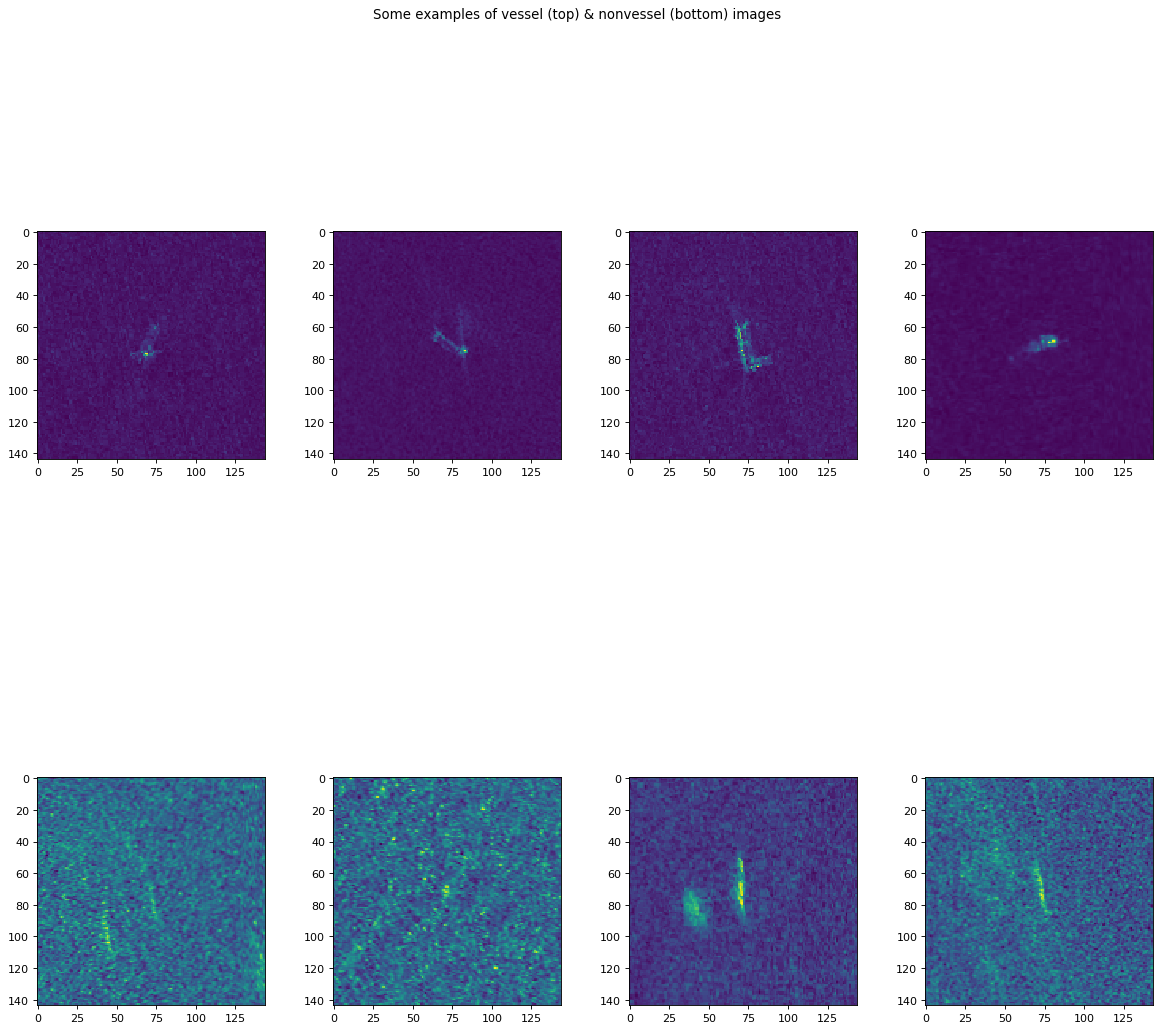

In [2]:
#Choose some datapoints of each class:
k = 4 #number of examples per class to visualize
vessels_to_visualize = np.random.randint(len(vessel_files), size=k)
nonvessels_to_visualize = np.random.randint(len(nonvessel_files), size=k)

#Visualize datapoints:
fig1 = plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
fig1.subplots_adjust(hspace=0.3, wspace=0.3)
fig1.suptitle("Some examples of vessel (top) & nonvessel (bottom) images", fontsize=12)
for i in range(k):
    ax = fig1.add_subplot(2, k, i+1)
    img_vessel = plt.imread(vessel_dir +"/"+vessel_files[vessels_to_visualize[i]])
    plt.imshow(img_vessel)
    ax = fig1.add_subplot(2, k, i+k+1)
    img_nonvessel = plt.imread(nonvessel_dir +"/"+nonvessel_files[nonvessels_to_visualize[i]])
    plt.imshow(img_nonvessel)

### Preprocessing

In [3]:
#Concatenate positives (vessels) & negatives (nonvessels)
# & construct label vector accordingly, using 1 & 0 to denote the two respective classes:
X = np.concatenate((vessels,nonvessels), axis = 2).T
y = np.concatenate((np.ones((1, len(vessel_files))), np.zeros((1, len(nonvessel_files)))), axis = 1).T

#Normalize data to [0,1] - Rescale all images by 1/65535 (65535 is the "naive" max value)
X = X/65535 # comment this out if using augmentation, or -TODO- move after augmentation

noise_added = 0 # Signifies no noise is added to the data (yet). Can change in next steps.

Perform train / validation(optional) / test split:

In [4]:
include_validation = 1 #1 to use a separate validation set during training, 0 to use test set

from sklearn.model_selection import train_test_split
#Split to train (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
if include_validation == 1:
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)
else:
    X_val = X_test
    y_val = y_test   

__Optional__ -- Preprocessing: Rebalance training set

In [5]:
#Re-balance training set by oversampling negatives?
# Indices of examples from each class
i_class0 = np.where(y_train == 0)[0] #non-vessels (minority)
i_class1 = np.where(y_train == 1)[0] #vessels (majority)
# Number of examples in each class
n_class0 = len(i_class0)
n_class1 = len(i_class1)
print("Before upsampling:")
print("Positives (vessels): "+str(n_class1))
print("Negatives (non-vessels): "+str(n_class0))
# For every example in class 1, randomly sample from class 0 with replacement
i_class0_upsampled = np.random.choice(i_class0, size=n_class1, replace=True)
# Join together class 0's upsampled target vector with class 1's target vector
y_train = np.concatenate((y_train[i_class0_upsampled], y_train[i_class1]))
#As above, for the features:
X_train = np.concatenate((X_train[i_class0_upsampled,:,:], X_train[i_class1,:,:]))
#Upsampled training set needs to be shuffled again:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)
print("After upsampling:")
print("Positives (vessels): "+str(len(np.where(y_train == 1)[0])))
print("Negatives (non-vessels): "+str(len(np.where(y_train == 0)[0])))

Before upsampling:
Positives (vessels): 1096
Negatives (non-vessels): 608
After upsampling:
Positives (vessels): 1096
Negatives (non-vessels): 1096


__Optional__ -- Preprocessing: Add some Gaussian noise to the training data

In [8]:
if noise_added == 1:
    print("Already added noise to training data!")
else:
    noise_added = 1 # raise flag that noise has been added so that this is not repeated
    #Add Gaussian noise with mean 0 & variance that of corresponding pixel accross training data
    pixelwise_mean = np.nanmean(X_train, axis = 0)
    pixelwise_std = np.nanstd(X_train, axis = 0)
    X_train = X_train + np.random.normal(np.zeros(X_train.shape), pixelwise_std)
    #Renormalize:
    X_train = (X_train - np.nanmin(X_train)) / (np.nanmax(X_train) - np.nanmin(X_train))
    print("Added Gaussian noise to training data & renormalized to [0,1].")

Added Gaussian noise to training data & renormalized to [0,1].


Reshape data to match Keras conventions:

In [6]:
#Reshape data to match Keras conventions:
X_train = X_train.reshape(-1, num_rows, num_cols, 1)
X_test = X_test.reshape(-1, num_rows, num_cols, 1)
X_val = X_val.reshape(-1, num_rows, num_cols, 1)

data_augmentation = 0 #flags that data augmentation is not applied yet (run next cell to change)

__Optional__ -- Augment training data:

In [15]:
#Data augmentation
#I. Using invariant transformations
data_augmentation = 1 #flags that data augmentation via transformations is applied

#Preprocess data using the ImageDataGenerator of Keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Rescale and then augment the training data using transformations
train_datagen = ImageDataGenerator(rescale=1./65535,
                                   #samplewise_center=True, 
                                   #samplewise_std_normalization=True,
                                   rotation_range=180,#value in degrees (0–180), a range within which to randomly rotate images
                                   width_shift_range=0.2,#range as fraction of total width within which to randomly translate images vertically
                                   height_shift_range=0.2,#range as fraction of total width within which to randomly translate images horizontally
                                   #shear_range=10,#randomly applying shearing transformations
                                   zoom_range=0.1)#randomly zooming inside pictures
                                   #horizontal_flip=True #randomly flipping half the images horizontally—relevant when there are no assumptions of horizontal asymmetry (for example,real-world pictures)
                                   #fill_mode='nearest') #the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift
                                   
#Rescale test data                                  
test_datagen = ImageDataGenerator(rescale=1./65535)#,
                                  #samplewise_center=True, 
                                  #samplewise_std_normalization=True)

#Each generator below yields batches of num_rows × num_cols greyscale (i.e. 1 channel) images 
#(shape (batch_size, num_rows, num_cols, 1)) and binary labels (shape (20,))
#TODO, replace flow with flow_from_directory...
train_generator = train_datagen.flow(X_train,
                                     y_train,
                                     batch_size=20)

validation_generator = test_datagen.flow(X_val,
                                         y_val,
                                         batch_size=len(y_val))
                                         #batch_size=20)

#Generators yield batches indefinitely so need to be told when to stop
for data_batch, labels_batch in train_generator:
    print('Data batch shape:', data_batch.shape)
    print('Labels batch shape:', labels_batch.shape)
    break
    
#II. TODO: Try using 1 GAN per class to generate more examples (can even use augmented data to train)

data batch shape: (20, 144, 144, 1)
labels batch shape: (20, 1)


Visualization -- __If data augmentation is used__, inspect some generated images:

In [10]:
if data_augmentation == 0:
    print("No data augmentation was used. Ignoring cell.")
else:     
    from tensorflow.keras.preprocessing import image

    image_id = 31 #ID of original image to augment -- feel free to change this.
    img_path = vessel_dir +"/"+ vessel_files[image_id] #augment vessel image image_id -- feel free to change this to nonvessel
    #img = image.load_img(img_path, target_size=(num_cols, num_rows))#read image & resize it
    img = plt.imread(img_path)
    x = image.img_to_array(img)#Converts it to a Numpy array with shape (144, 144, 1)
    x = x.reshape((1,) + x.shape)#Reshape it to (1, 144, 144, 1)
    i=0

    #Generates batches of randomly transformed images.   
    for batch in train_datagen.flow(x, batch_size=1):
       plt.figure(i+1)
       imgplot = plt.imshow(image.array_to_img(batch[0]))
       i += 1
       if i % 4 == 0:
           break#Loops indefinitely, so you need to break the loop at some point!  

No data augmentation was used. Ignoring cell.


### Training the CNN

In [7]:
#Import necessary Keras packages:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping

#### Pick one of the two options below:

#### 1. Use only Keras (easier to train & check model history but can't calibrate final model's predictions)

Architecture:

In [8]:
sklearn_wrapper = 0 #raise flag that a Scikit-Learn wrapper of Keras is not used 

#Define the CNN architecture:
model = models.Sequential()
model.add(layers.Conv2D(32, kernel_size = 3, activation='relu', input_shape=(num_rows, num_cols, 1)))
model.add(layers.Conv2D(32, kernel_size = 3, activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, kernel_size = 3, activation='relu'))
model.add(layers.Conv2D(64, kernel_size = 3, activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, kernel_size = 3, activation='relu'))
model.add(layers.Conv2D(128, kernel_size = 3, activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
#model.add(layers.Conv2D(256, kernel_size = 3, activation='relu'))
#model.add(layers.Conv2D(256, kernel_size = 3, activation='relu'))
#model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

#Visualize & save model architecture
print(model.summary())
#Needs pydot & graphviz installed:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 142, 142, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 140, 140, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 70, 70, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 68, 68, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 66, 66, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 33, 33, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 31, 31, 128)       7

Optimization:

In [9]:
#Compile model, defining loss function and optimizer:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])#use accuracy as the evaluation metric

Early stopping, train model & track training history:

In [10]:
#The training will use early stopping based on the validation loss:
es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   verbose=1,
                   patience=20,
                   restore_best_weights = True)

#Train model & track training history
if data_augmentation == 0: #if no data augmentation is applied, use original training data
    history = model.fit(X_train, y_train, 
                        epochs=100,
                        batch_size=4,
                        shuffle=True,
                        validation_data=(X_val, y_val),
                        callbacks=[es]) 
else:
    history = model.fit_generator(train_generator, #if data augmentation (transforms) is applied, use transformed training data
                              steps_per_epoch=500,#tells generator when to stop; here 500 batches of size 20 means training set has size 10000 
                              epochs=30,
                              validation_data=validation_generator,#validation set can be a generator or a tuple of numpy arrays
                              validation_steps=1, #as the validation set here is produced by a generator, it needs to know when to stop for now use 42x20 = 840 of the 853 test set examples. Will change...
                              callbacks=[es])

#Store some of the model's training history in easy to use variables for plotting
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

#Save model after training
model.save('VesselDetectorNew.h5')

Train on 2192 samples, validate on 568 samples
Epoch 1/100
2192/2192 [==============================] - 125s 57ms/sample - loss: 0.5062 - acc: 0.7235 - val_loss: 0.4104 - val_acc: 0.8556
Epoch 2/100
2192/2192 [==============================] - 121s 55ms/sample - loss: 0.4056 - acc: 0.8184 - val_loss: 0.3598 - val_acc: 0.8609
Epoch 3/100
2192/2192 [==============================] - 120s 55ms/sample - loss: 0.3869 - acc: 0.8216 - val_loss: 0.4016 - val_acc: 0.8433
Epoch 4/100
2192/2192 [==============================] - 124s 57ms/sample - loss: 0.3751 - acc: 0.8362 - val_loss: 0.4769 - val_acc: 0.8134
Epoch 5/100
2192/2192 [==============================] - 125s 57ms/sample - loss: 0.3632 - acc: 0.8453 - val_loss: 0.3444 - val_acc: 0.8556
Epoch 6/100
2192/2192 [==============================] - 126s 57ms/sample - loss: 0.3496 - acc: 0.8522 - val_loss: 0.3312 - val_acc: 0.8556
Epoch 7/100
2192/2192 [==============================] - 122s 56ms/sample - loss: 0.3432 - acc: 0.8568 - val_loss

Visualization -- Plot validation & training accuracy per epoch:

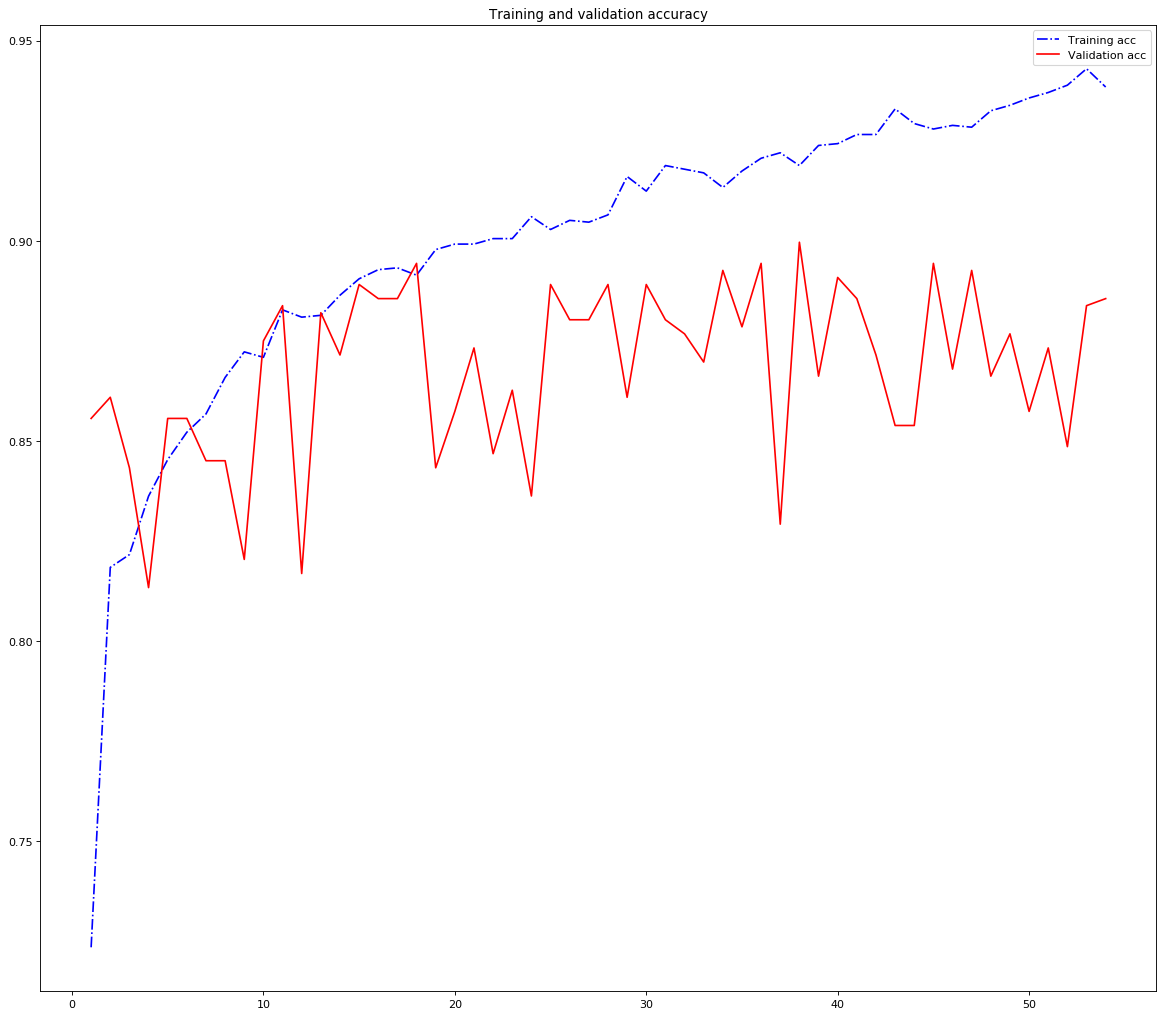

In [11]:
plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(epochs, acc, color = 'blue', linestyle='-.', label='Training acc')
plt.plot(epochs, val_acc, color = 'red', linestyle='-', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

Visualization -- Plot validation & training loss per epoch:

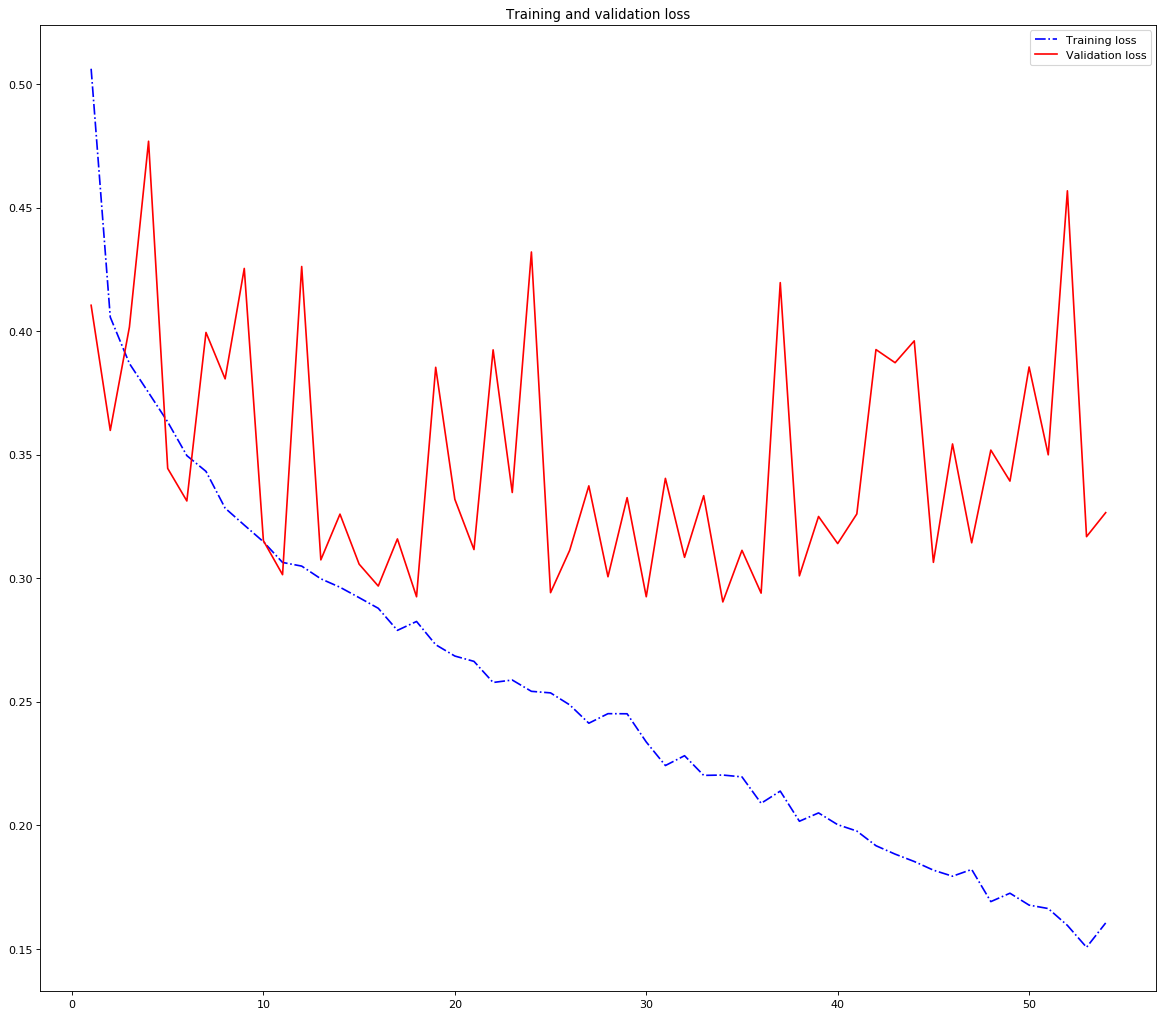

In [12]:
plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(epochs, loss, 'blue', linestyle='-.', label='Training loss')
plt.plot(epochs, val_loss, 'red',  linestyle='-', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

#### 2. Use Keras & Scikit-Learn wrapper (allows to calibrate the final model's predictions)

In [8]:
sklearn_wrapper = 1 #raise flag that a Scikit-Learn wrapper of Keras is used 
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
#Define a function to create model:
def create_model():
    #Define the CNN architecture:
    model = models.Sequential()
    model.add(layers.Conv2D(32, kernel_size = 3, activation='relu', input_shape=(num_rows, num_cols, 1)))
    model.add(layers.Conv2D(32, kernel_size = 3, activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, kernel_size = 3, activation='relu'))
    model.add(layers.Conv2D(64, kernel_size = 3, activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, kernel_size = 3, activation='relu'))
    model.add(layers.Conv2D(128, kernel_size = 3, activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    #model.add(layers.Conv2D(256, kernel_size = 3, activation='relu'))
    #model.add(layers.Conv2D(256, kernel_size = 3, activation='relu'))
    #model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    #Compile model, defining loss function and optimizer:
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.RMSprop(lr=1e-4),
                  metrics=['acc'])#use accuracy as the evaluation metric
    return model

#Create model (& train directly)
model = KerasClassifier(build_fn=create_model,
                        epochs=4,
                        batch_size=4,
                        verbose=0) 
model.fit(X_train, y_train)

### Evaluation on test data

__If not evaluating the same model you just trained__, run cell below to load another one. Otherwise, ignore.

In [19]:
#Load a trained model
from tensorflow.keras.models import load_model
model = load_model('VesselDetectorBest.h5') #Name of model to add

#Visualize loaded model's architecture
print("Model Loaded")
print(model.summary())

Model Loaded
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 142, 142, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 140, 140, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 70, 70, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 68, 68, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 66, 66, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 33, 33, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 31, 31,

Store final model's predictions on the test set:

In [14]:
if sklearn_wrapper == 0: #use keras interface
    y_pred = model.predict_classes(X_test)# predict classes for test set
    y_prob_pred = model.predict_proba(X_test)#[:,1]# predict class probabilities for test set 
else: #use sklearn interface
    y_pred = model.predict(X_test)# predict classes for test set
    y_prob_pred = model.predict_proba(X_test)[:,1]# predict class probabilities for test set 
        
#Get confusion matrix (and isolate entries) on the test set:
from sklearn import metrics
conf_mat = metrics.confusion_matrix(y_test, y_pred)
TN = conf_mat[0][0]
FP = conf_mat[0][1]
TP = conf_mat[1][1]
FN = conf_mat[1][0]

Visualization -- Show confusion matrix:

Confusion matrix, without normalization
[[178  35]
 [ 37 319]]


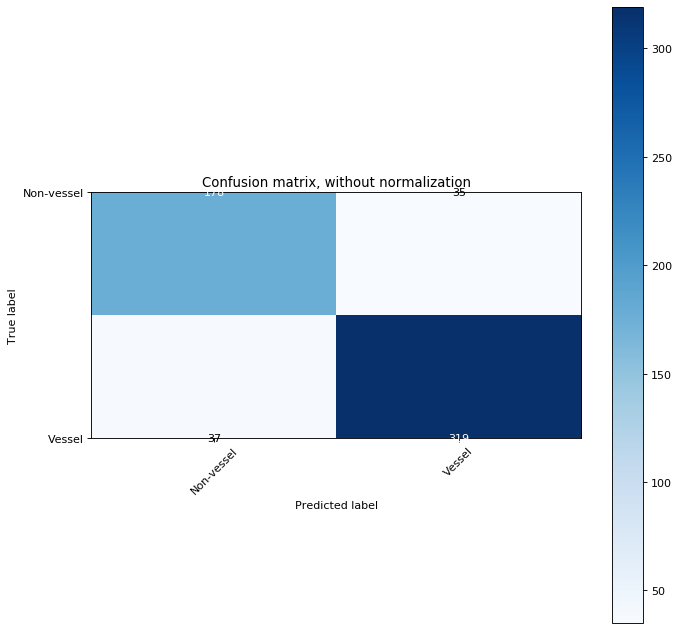

In [72]:
# For sklearn 0.22 and later one of these 2 should work:
# #Option A:
# disp = metrics.plot_confusion_matrix(model, X_test, y_test,
#                              display_labels=["Non-vessel", "Vessel"],
#                              cmap=plt.cm.Blues,
#                              normalize=normalize)
# disp.ax_.set_title("Confusion matrix, without normalization")
# print(disp.confusion_matrix)
# plt.show()
#
# #Option B:
#disp = metrics.ConfusionMatrixDisplay(conf_mat, ["Non-vessel", "Vessel"])

# For earlier versions of sklearn than 0.22 and later use one of these:
# Option A:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes)) 
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 verticalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

#np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(9, 8), dpi= 80, facecolor='w', edgecolor='k')
plot_confusion_matrix(conf_mat, classes=["Non-vessel", "Vessel"],
                      title='Confusion matrix, without normalization')
plt.show()

# #Option B:
# import seaborn as sn
# import pandas as pd
# classes=["Non-vessel", "Vessel"]
# df_cm = pd.DataFrame(conf_mat, index=classes, columns=classes)
# # plt.figure(figsize=(10,7))
# sn.set(font_scale=1.4) # for label size
# sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
# plt.show()

Visualization -- Classification evaluation measures -- Accuracy, Precision, Recall, F1-score, AUC, Jaccard Index & Cohen's Kappa, as well as the Expected Accuracy of a random classifier for reference:

Expected Accuracy: 0.5306970265102962, i.e. if we were randomly assigning examples.
For all measures below, the higher the better:
Accuracy: 0.8734622144112478
Recall: 0.8960674157303371
Precision: 0.9011299435028248
F1-score: 0.8985915492957746
Jaccard Index: 0.8158567774936062
Cohen's Kappa: 0.7303707993839755
AUC (using class predictions): 0.8658740834520231
AUC (using scores): 0.94495437041726


[]

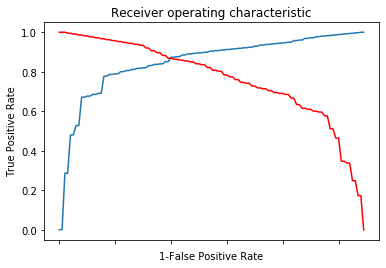

In [73]:
#Compute accuracy, precision, recall, f1-score, Jaccard index & Cohen's Kappa:
from sklearn import metrics

Accuracy = (TP+TN) / (TP+FN+FP+TN)
Recall = TP / (TP+FN)
Precision = TP / (TP+FP) 
F1_score = 2*(Recall*Precision) / (Recall+Precision)
Jaccard_index = TP / (TP+FN+FP)

Expected_Accuracy = ((TN+FP)*(TN+FN)+(FN+TP)*(FP+TP)) / (TN+TP+FN+FP)**2
Cohens_Kappa = (Accuracy - Expected_Accuracy) / (1 - Expected_Accuracy)

#Compute Area Under ROC curve:
#1. Using class predictions (i.e. after decisions):
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
AUC_decisions = metrics.auc(fpr, tpr)
#2. Using scores (i.e. before decisions):
AUC_scores = metrics.roc_auc_score(y_test, y_prob_pred)
fpr_scores, tpr_scores, thresholds_scores = metrics.roc_curve(y_test, y_prob_pred)

#Print measures:
print("Expected Accuracy: "+str(Expected_Accuracy)+ "i.e. Accuracy of a classifier randomly assigning examples to the 2 classes (deviation from 0.5 indicates class imbalance).")
print("For all measures below, the higher the better:")
print("Accuracy: "+str(Accuracy))
print("Recall: "+str(Recall))
print("Precision: "+str(Precision))
print("F1-score: "+str(F1_score))
print("Jaccard Index: "+str(Jaccard_index))
print("Cohen's Kappa: "+str(Cohens_Kappa))
print("AUC (using class predictions): "+str(AUC_decisions))
print("AUC (using scores): "+str(AUC_scores))

import pandas as pd
i = np.arange(len(tpr_scores)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr_scores, index=i),'tpr' : pd.Series(tpr_scores, index = i), '1-fpr' : pd.Series(1-fpr_scores, index = i), 'tf' : pd.Series(tpr_scores - (1-fpr_scores), index = i), 'thresholds' : pd.Series(thresholds_scores, index = i)})
roc.iloc[(roc.tf-0).abs().argsort()[:1]]

# Plot ROC curve
fig, ax = plt.subplots()
plt.plot(roc['tpr'])
plt.plot(roc['1-fpr'], color = 'red')
plt.xlabel('1-False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
ax.set_xticklabels([])

Visualization -- Probability estimation inspection / evaluation measures -- histograms of scores, Brier Score & Reliability Curve:

Brier Score: 0.10428048483884228 -- lower means better probability estimation


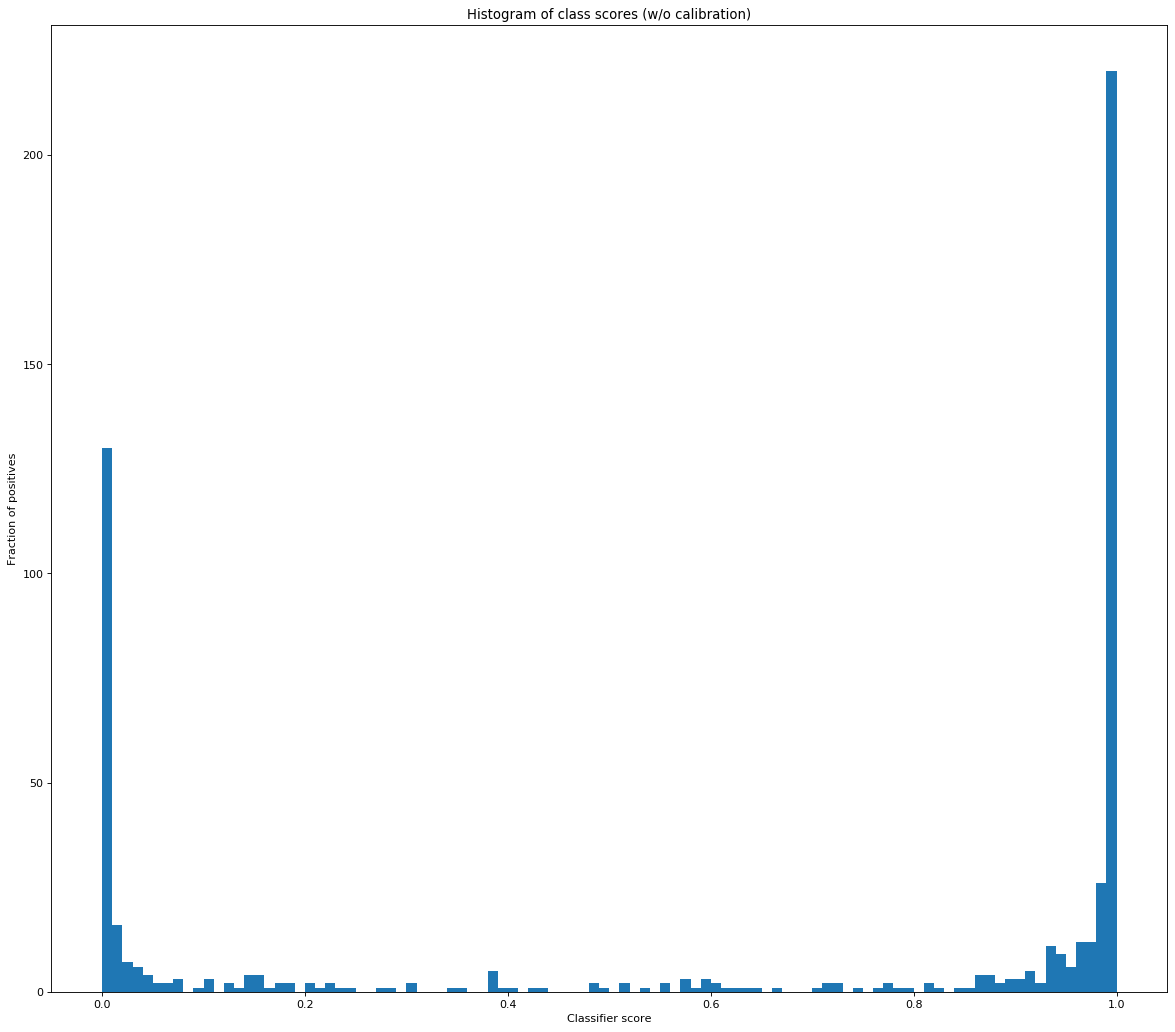

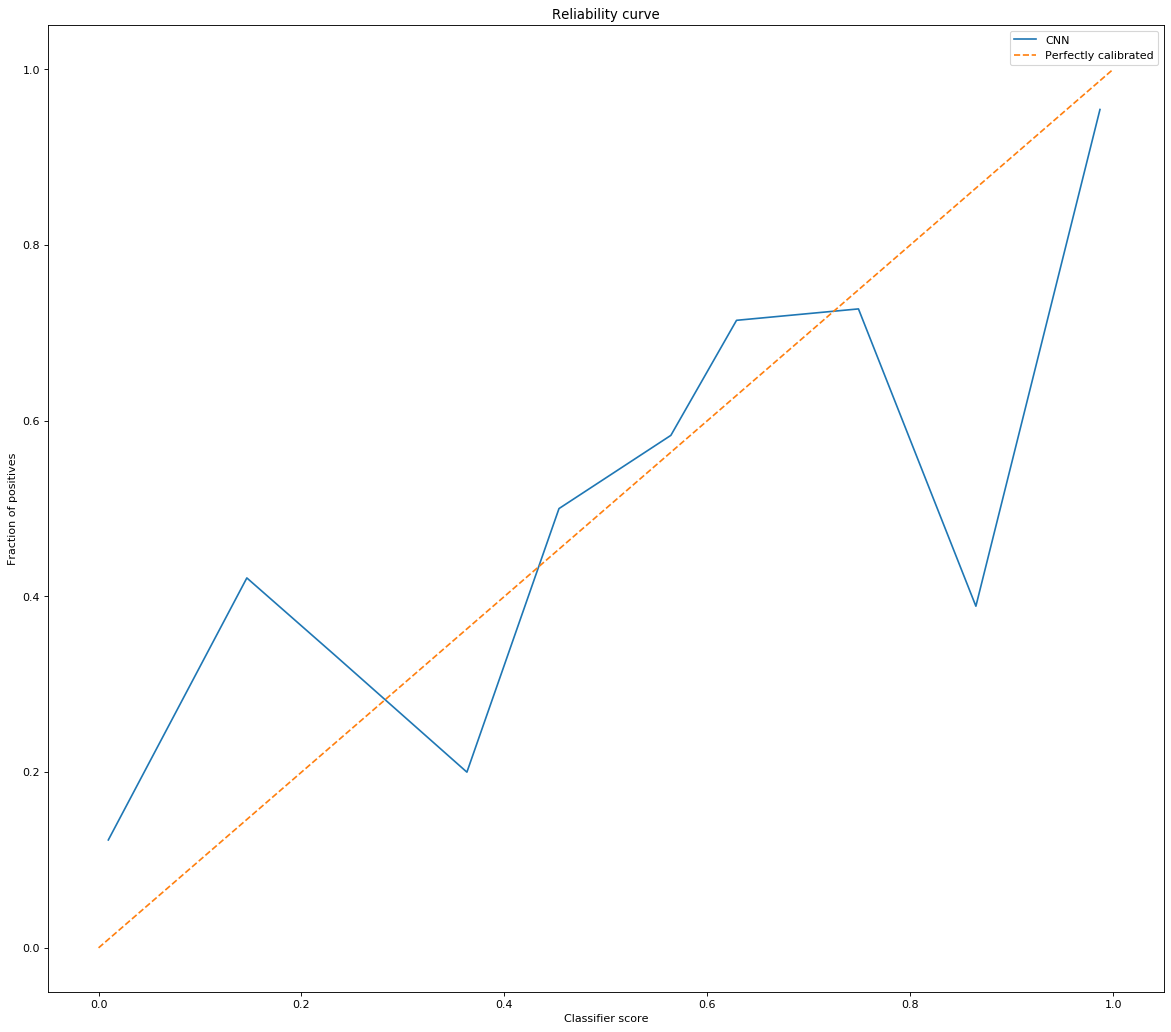

In [71]:
#Compute Brier score
from sklearn import metrics
brier_score = metrics.brier_score_loss(y_test, y_prob_pred) 
print("Brier Score: "+str(brier_score)+" -- lower means better probability estimation")

#Plot histogram of scores
plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.hist(y_prob_pred, bins = 100)
plt.ylabel('Fraction of positives')
plt.xlabel('Classifier score')
plt.title("Histogram of class scores (w/o calibration)")

#Plot reliability curve
from sklearn.calibration import calibration_curve
probablities = np.arange(0, 1.2, 0.2)
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_prob_pred, n_bins=10)
plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(mean_predicted_value, fraction_of_positives, label="CNN")
plt.plot(probablities, probablities, "--", label="Perfectly calibrated")
plt.legend()
plt.xlim([-0.05, 1.05])
plt.ylabel('Fraction of positives')
plt.xlabel('Classifier score')
plt.title("Reliability curve")
plt.show()

__Optional__ -- Incorporate thresholding with / w/o calibration: <font color='red'>TODO</font> -- Fix issue with calibration

In [77]:
#Classify according to prior...
y_pred_thresh = np.zeros((len(y_test),1))

#1. Either use training set prior as threshold:
#Prior probability of positive examples (vessels) in training set (before resampling):
prior = n_class1 / (n_class1+n_class0)
print("Prior of 'vessel' (positive class) in training data: "+str(prior))
thresh = prior

# #2. Or compute AUC maximizing threshold on training set:
# from sklearn import metrics
# #Calculate optimal threshold based on AUC
# def Find_Optimal_Cutoff(target, predicted):
#     fpr, tpr, threshold = metrics.roc_curve(target, predicted)
#     i = np.arange(len(tpr)) 
#     roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
#     roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

#     return list(roc_t['threshold']) 

# # Find optimal probability threshold on validation set
# y_prob_pred_val = model.predict(X_val)#get probability estimates on validation set
# threshold_opt = Find_Optimal_Cutoff(y_val, y_prob_pred_val)
# print("Optimal threshold on validation set is : " +str(threshold_opt))
# # on test this is ~ [0.5479457378387451]
# thresh = threshold_opt 

#--------------------Calibration (optional, comment to ignore)--------------------
if sklearn_wrapper == 1: #using sklearn wrapper
    #Perform isotonic regression or Platt calibration on scores of validation set using 5-fold CV:
    from sklearn.calibration import CalibratedClassifierCV
    model_cal = CalibratedClassifierCV(model, cv='prefit', method='isotonic') #'sigmoid' for Platt
    model_cal.fit(X_val.astype(np.float32), np.squeeze(y_val).astype(np.float32))
    y_prob_pred = model_cal.predict_proba(X_test.astype(np.float32))[:, 1]#now calibrate scores of test set examples
    print("Probability estimates calibrated on separate validation set.")
else: # not using sklearn wrapper
    #print("WARNING! Calibration skipped as it requires using a sklearn wrapper for Keras.") 
    # #----------------If no sklearn wrapper is used, refine code below------------------
    y_prob_pred_val = model.predict_proba(X_val)# get class probabilities on validation set
    #Fit a Platt/logistic calibrator on validation set:
#     from sklearn.linear_model import LogisticRegression
#     cal = LogisticRegression(penalty='none', class_weight='balanced', solver = 'lbfgs')
#     cal.fit(y_prob_pred_val.reshape(-1, 1), y_val.ravel())
#     y_prob_pred_calibrated = cal.predict_proba(y_prob_pred.reshape(-1, 1))[:,1]
#     y_prob_pred_calibrated = np.nan_to_num(y_prob_pred_calibrated)
    #Fit an isotonic regression calibrator on validation set:
    from sklearn.isotonic import IsotonicRegression
    cal = IsotonicRegression()
    cal.fit(np.float32(np.squeeze(y_prob_pred_val)), np.float32(np.squeeze(y_val)))
    y_prob_pred_calibrated = cal.predict(np.float32(np.squeeze(y_prob_pred)))
    y_prob_pred_calibrated = np.nan_to_num(y_prob_pred_calibrated)
    print("Probability estimates calibrated on validation set.")
#----------------------------------------------------------------------------------

y_pred_thresh[y_prob_pred>thresh] = 1

#New confusion matrix & isolated entries
from sklearn import metrics
conf_mat = metrics.confusion_matrix(y_test, y_pred_thresh)
TN = conf_mat[0][0]
FP = conf_mat[0][1]
TP = conf_mat[1][1]
FN = conf_mat[1][0]

Prior of 'vessel' (positive class) in training data: 0.653755868544601
Probability estimates calibrated on validation set.


Visualization -- __If thresholding / calibration is applied__, repeat evaluation:

Expected Accuracy: 0.5227467174860468, i.e. if we were randomly assigning examples.
For all measures below, the higher the better:
Accuracy: 0.8664323374340949
Recall: 0.8651685393258427
Precision: 0.9166666666666666
F1-score: 0.8901734104046243
Jaccard Index: 0.8020833333333334
Cohen's Kappa: 0.7201325429081777
AUC (using class predictions): 0.8658740834520231
AUC (using scores): 0.94495437041726


[]

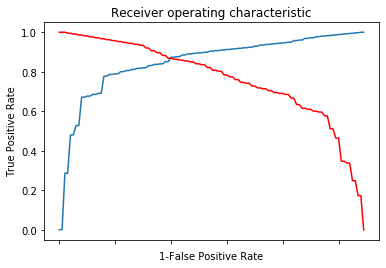

In [78]:
#Compute accuracy, precision, recall, f1-score, Jaccard index & Cohen's Kappa:
from sklearn import metrics

Accuracy = (TP+TN) / (TP+FN+FP+TN)
Recall = TP / (TP+FN)
Precision = TP / (TP+FP) 
F1_score = 2*(Recall*Precision) / (Recall+Precision)
Jaccard_index = TP / (TP+FN+FP)

Expected_Accuracy = ((TN+FP)*(TN+FN)+(FN+TP)*(FP+TP)) / (TN+TP+FN+FP)**2
Cohens_Kappa = (Accuracy - Expected_Accuracy) / (1 - Expected_Accuracy)

#Compute Area Under ROC curve:
#1. Using class predictions (i.e. after decisions):
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
AUC_decisions = metrics.auc(fpr, tpr)
#2. Using scores (i.e. before decisions):
AUC_scores = metrics.roc_auc_score(y_test, y_prob_pred)
fpr_scores, tpr_scores, thresholds_scores = metrics.roc_curve(y_test, y_prob_pred)

#Print measures:
print("Expected Accuracy: "+str(Expected_Accuracy)+ ", i.e.  Accuracy of a classifier randomly assigning examples to the 2 classes (deviation from 0.5 indicates class imbalance).")
print("For all measures below, the higher the better:")
print("Accuracy: "+str(Accuracy))
print("Recall: "+str(Recall))
print("Precision: "+str(Precision))
print("F1-score: "+str(F1_score))
print("Jaccard Index: "+str(Jaccard_index))
print("Cohen's Kappa: "+str(Cohens_Kappa))
print("AUC (using class predictions): "+str(AUC_decisions))
print("AUC (using scores): "+str(AUC_scores))

import pandas as pd
i = np.arange(len(tpr_scores)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr_scores, index=i),'tpr' : pd.Series(tpr_scores, index = i), '1-fpr' : pd.Series(1-fpr_scores, index = i), 'tf' : pd.Series(tpr_scores - (1-fpr_scores), index = i), 'thresholds' : pd.Series(thresholds_scores, index = i)})
roc.iloc[(roc.tf-0).abs().argsort()[:1]]

# Plot ROC curve
fig, ax = plt.subplots()
plt.plot(roc['tpr'])
plt.plot(roc['1-fpr'], color = 'red')
plt.xlabel('1-False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
ax.set_xticklabels([])

Visualization -- __If calibration is applied__, show again probability estimation inspection / evaluation measures -- histogram of scores, Brier Score, Reliability Curve:

Brier Score (calibrated): 0.09853100399643666 -- lower means better probability estimation


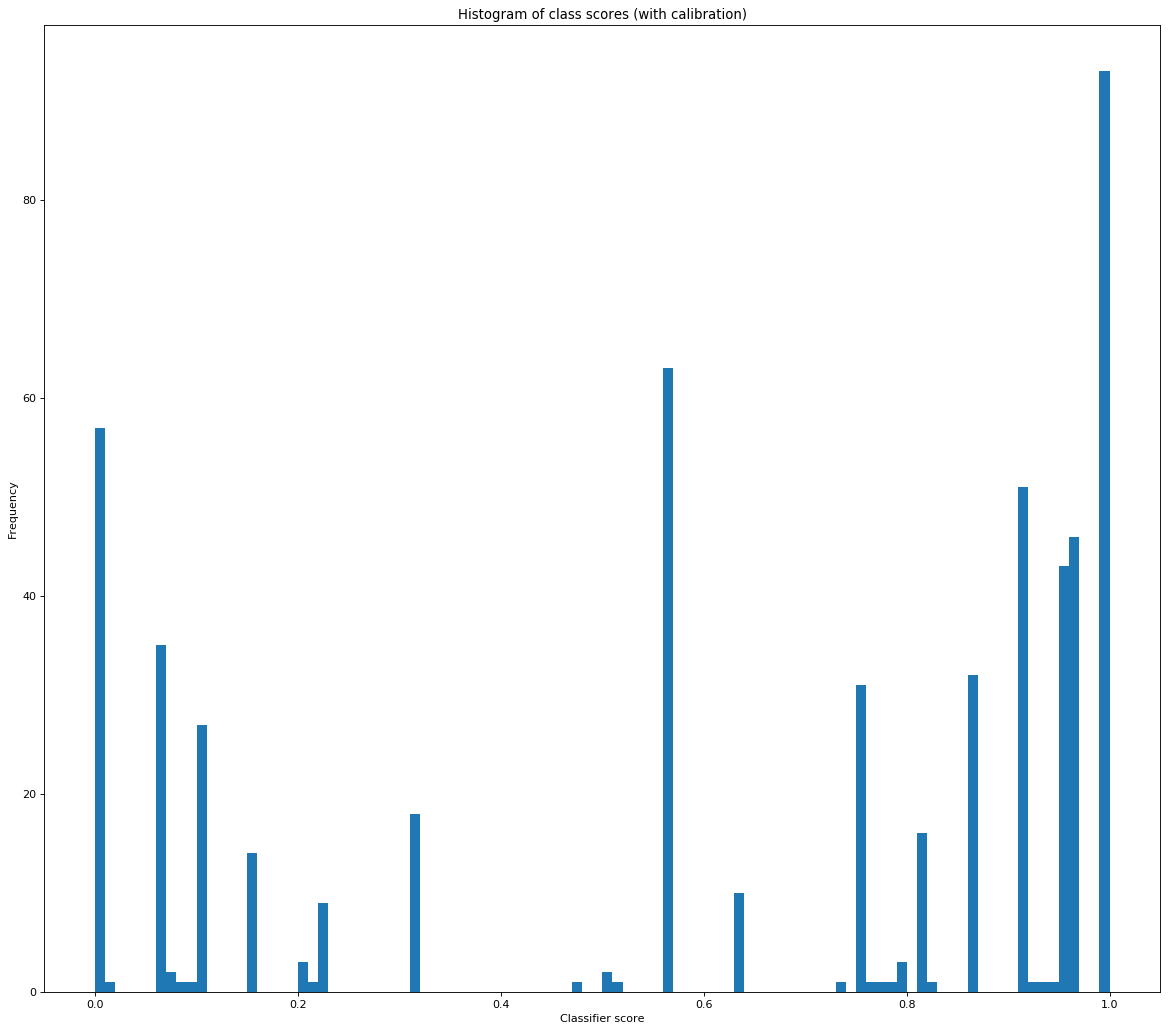

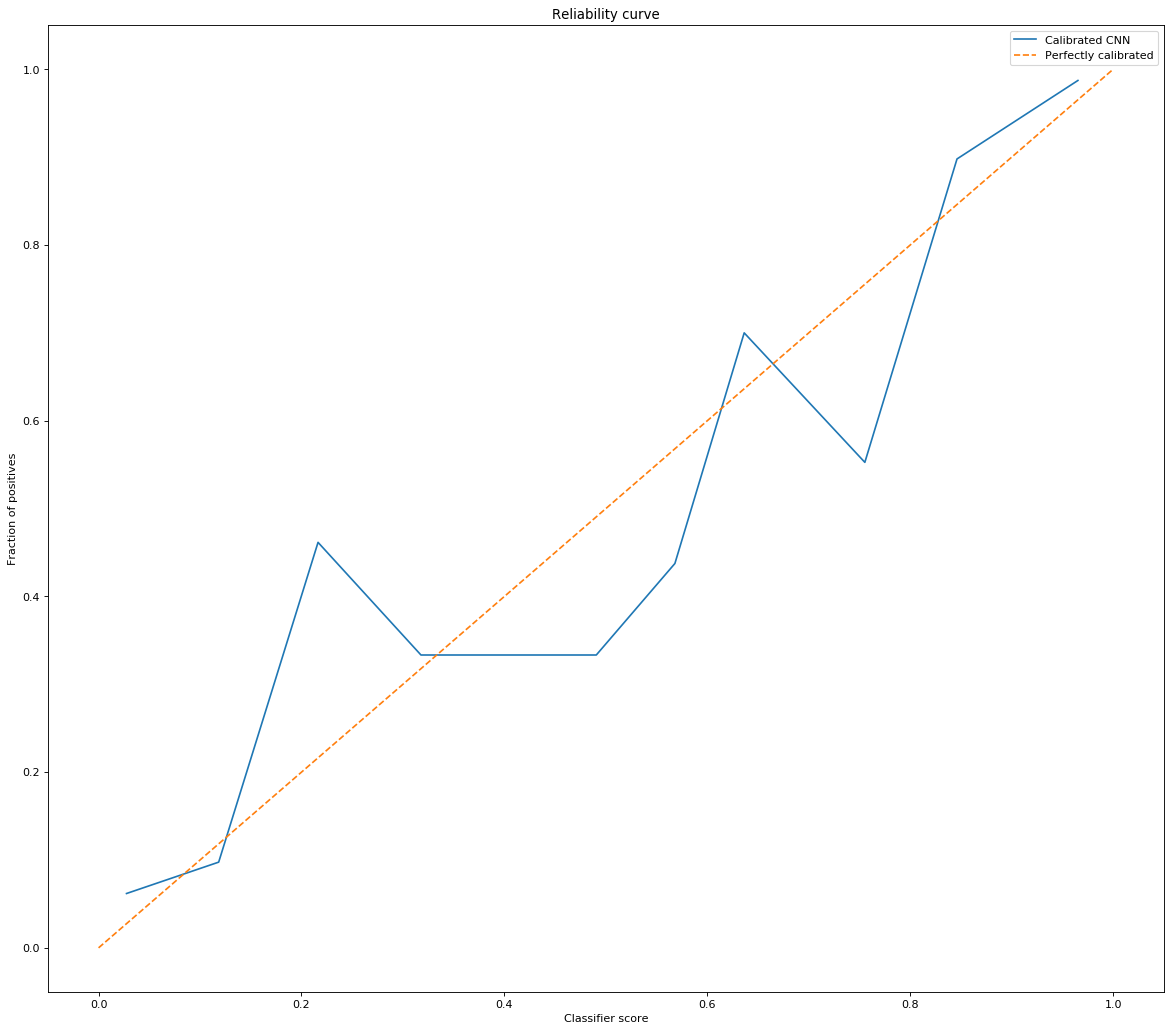

In [79]:
#Compute Brier score
from sklearn import metrics
brier_score = metrics.brier_score_loss(y_test, y_prob_pred_calibrated) 
print("Brier Score (calibrated): "+str(brier_score)+" -- lower means better probability estimation")

#Plot histogram of scores
plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.hist(y_prob_pred_calibrated, bins = 100)  
plt.ylabel('Frequency')
plt.xlabel('Classifier score')
plt.title("Histogram of class scores (with calibration)")

#Plot reliability curve
from sklearn.calibration import calibration_curve
probablities = np.arange(0, 1.2, 0.2)
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_prob_pred_calibrated, n_bins=10)
plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(mean_predicted_value, fraction_of_positives, label="Calibrated CNN")
plt.plot(probablities, probablities, "--", label="Perfectly calibrated")
plt.legend()
plt.xlim([-0.05, 1.05])
plt.ylabel('Fraction of positives')
plt.xlabel('Classifier score')
plt.title("Reliability curve")
plt.show()

Visualization -- Visualize some FPs and some FNs:

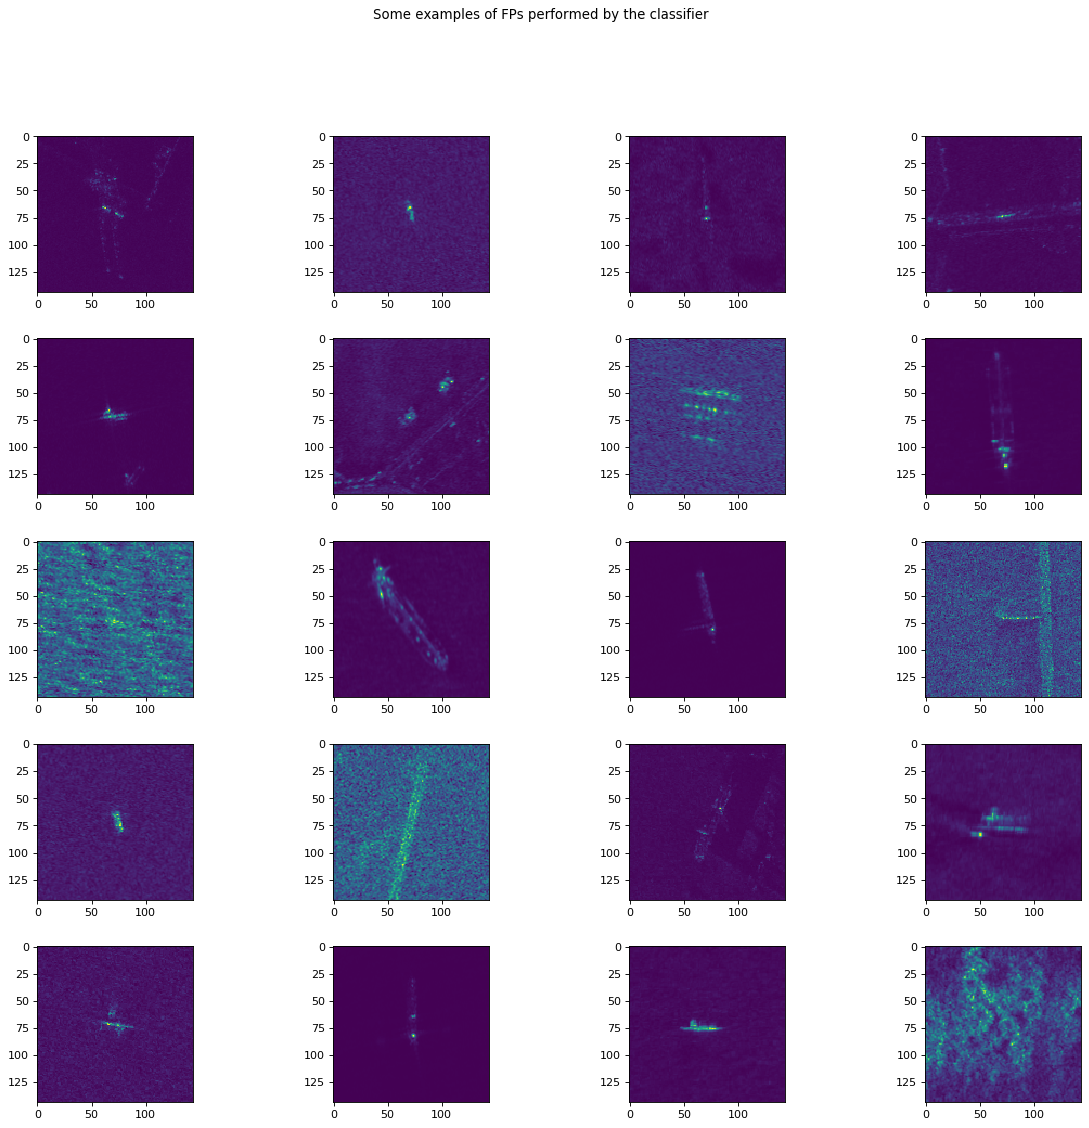

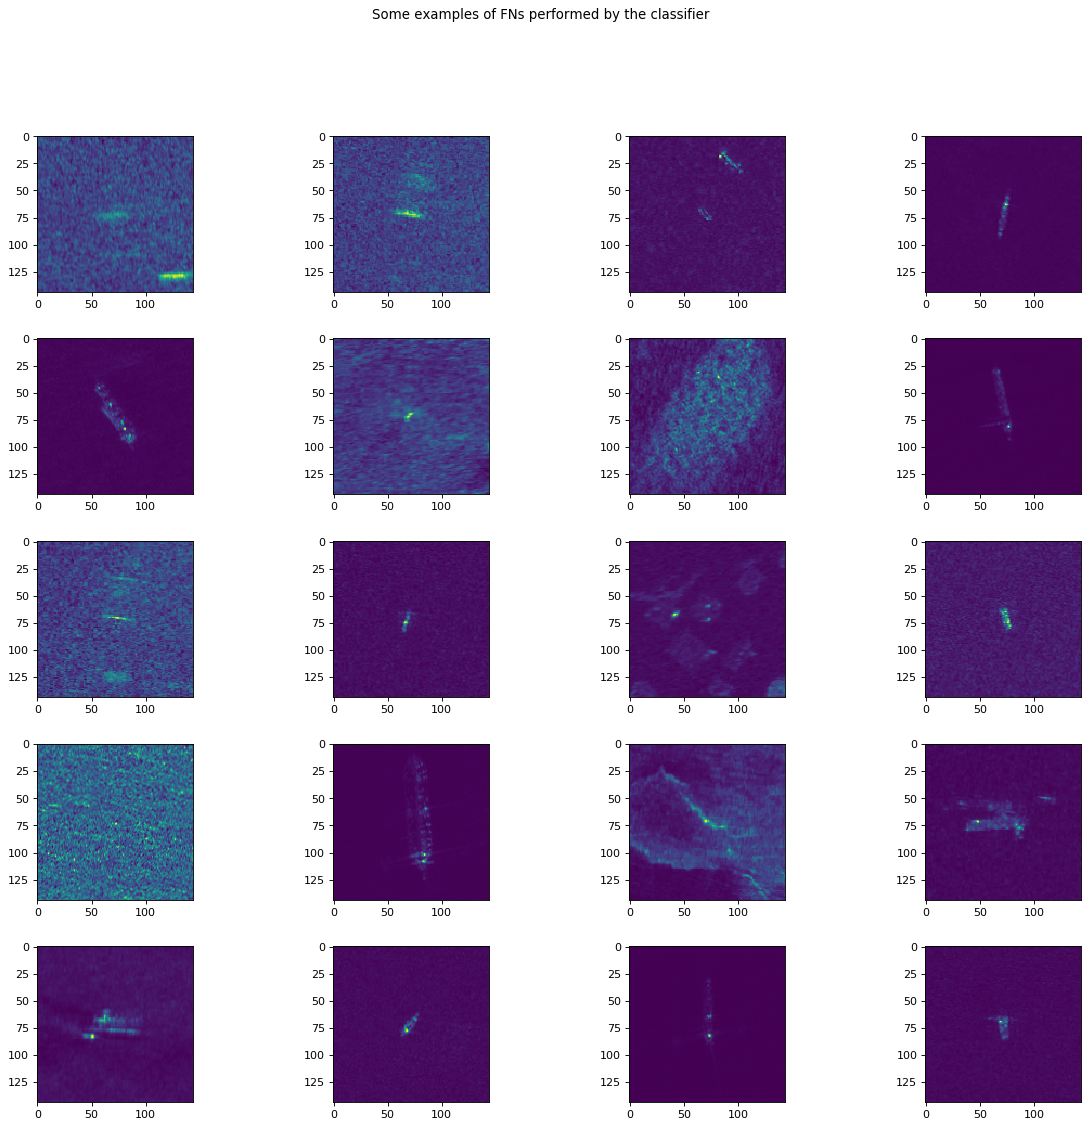

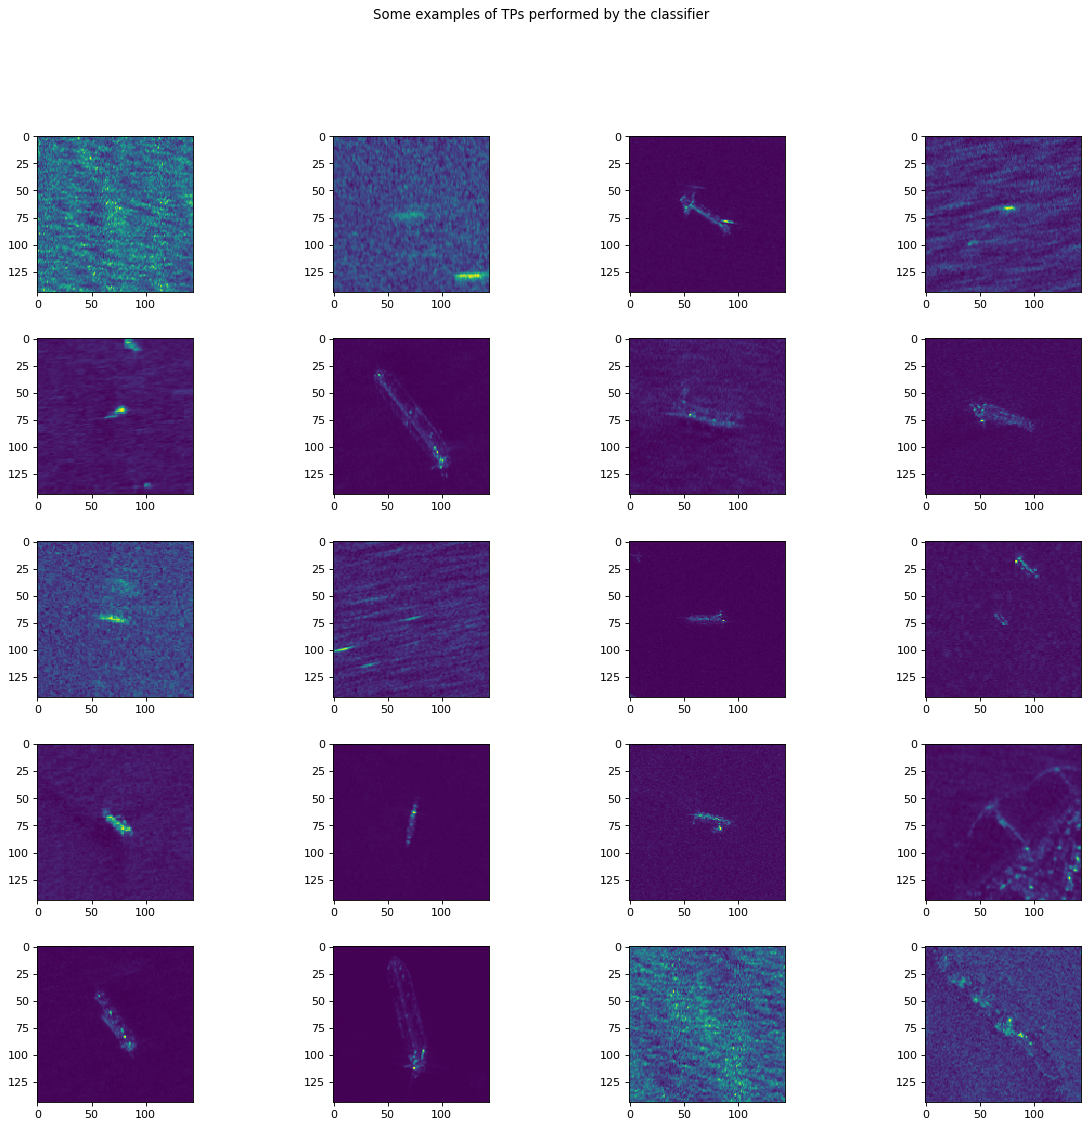

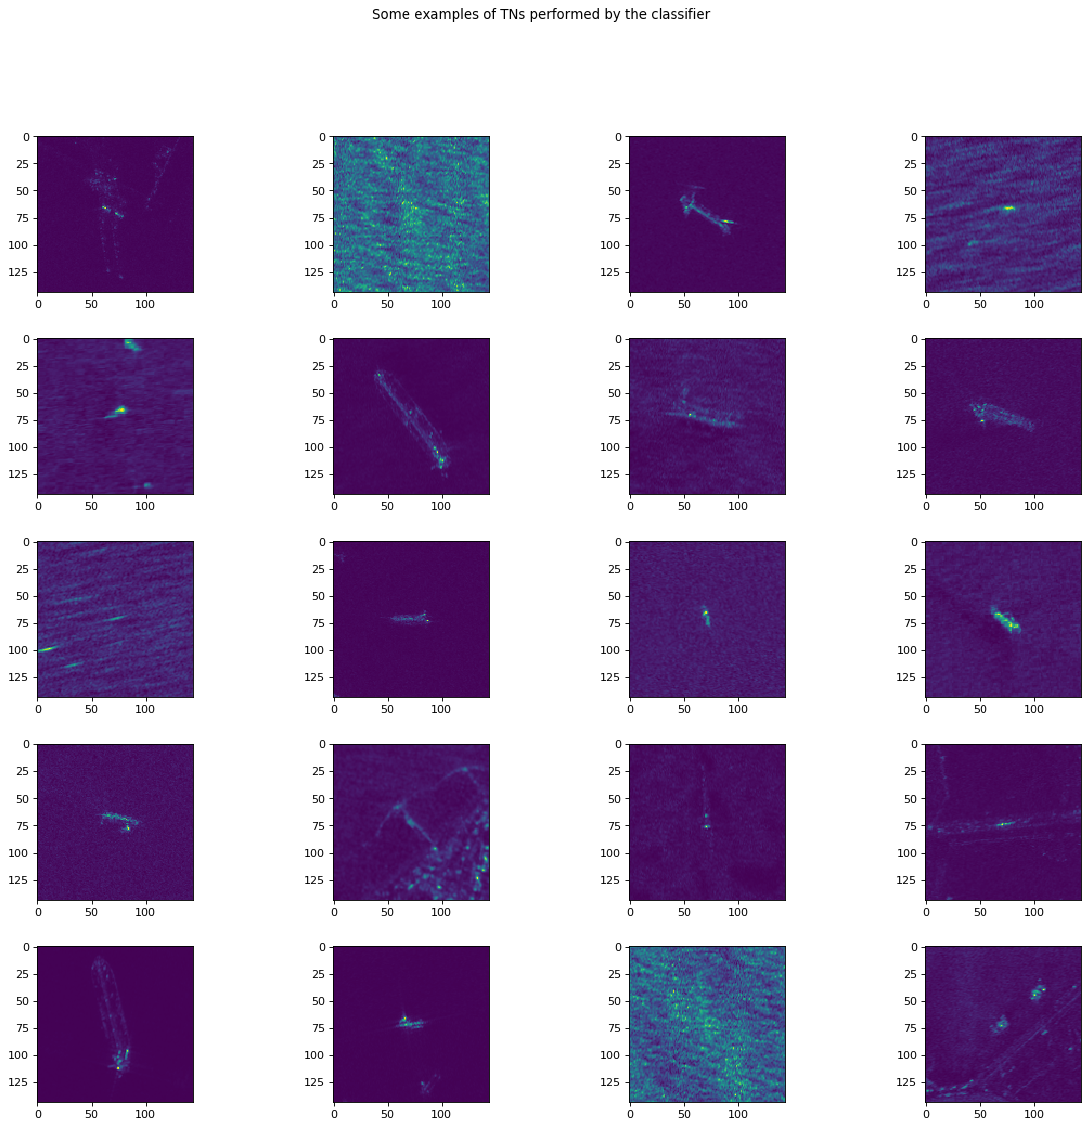

In [16]:
#Create lists of TPs, TNs, FPs, FNs:
TP_indices_list = np.where(y_test[np.where(y_pred==1)[0]]==1)[0]
TN_indices_list = np.where(y_test[np.where(y_pred==0)[0]]==0)[0]
FP_indices_list = np.where(y_test[np.where(y_pred==1)[0]]==0)[0]
FN_indices_list = np.where(y_test[np.where(y_pred==0)[0]]==1)[0]

from tensorflow.keras.preprocessing import image

k=20 #Number of TPs & FPs to plot

fig0 = plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
fig0.subplots_adjust(hspace=0.3, wspace=0.3)
fig0.suptitle("Some examples of FPs performed by the classifier", fontsize=12)
for i in range(k):
    ax = fig0.add_subplot(5, 4, i+1)
    img_FP = X_test[FP_indices_list[i],:,:,:]
    plt.imshow(image.array_to_img(img_FP))

fig1 = plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
fig1.subplots_adjust(hspace=0.3, wspace=0.3)
fig1.suptitle("Some examples of FNs performed by the classifier", fontsize=12)
for i in range(k):
    ax = fig1.add_subplot(5, 4, i+1)
    img_FN = X_test[FN_indices_list[i],:,:,:]
    plt.imshow(image.array_to_img(img_FN))
    
fig2 = plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
fig2.subplots_adjust(hspace=0.3, wspace=0.3)
fig2.suptitle("Some examples of TPs performed by the classifier", fontsize=12)
for i in range(k):
    ax = fig2.add_subplot(5, 4, i+1)
    img_TP = X_test[TP_indices_list[i],:,:,:]
    plt.imshow(image.array_to_img(img_TP))

fig3 = plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
fig3.subplots_adjust(hspace=0.3, wspace=0.3)
fig3.suptitle("Some examples of TNs performed by the classifier", fontsize=12)
for i in range(k):
    ax = fig3.add_subplot(5, 4, i+1)
    img_TN = X_test[TN_indices_list[i],:,:,:]
    plt.imshow(image.array_to_img(img_TN))    

### Visualising Features & Interpreting Predictions

Visualization -- Visualize the images to which the filters (of the convolutional layers) of the trained CNN are maximally sensitive. In other words, the visual patterns to which each filter is meant to respond. TODO: Make compatible with TF2?

In [29]:
#Procedure:
#1) build a loss function that maximizes the value of a given filter in a given convolution layer
#2) use stochastic gradient descent to adjust the values of the input image so as to maximize this activation value

# This example -- loss for the activation of filter 0 in the layer conv2d_34 of the CNN

from tensorflow.keras import models
from tensorflow.keras import backend as K
import numpy as np
import matplotlib.pyplot as plt    

model = models.load_model('VesselDetectorBest.h5')

model.summary()

layer_name = 'conv2d_34'
filter_index = 0
    
#Function to convert output of above into a valid tensor
def deprocess_image(x):
    #Normalize the tensor: center on 0, ensure that std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    #Clip to [0,1]
    x += 0.5
    x = np.clip(x, 0, 1)
    #Convert to a .tiff array
    x *= 65535
    x = np.clip(x, 0, 65535).astype('uint8')
    return x
    
#The following function will take as input a layer name and a filter index
#and return a valid image tensor representing the pattern that maximizes
#the activation of that filter
    
def generate_pattern(layer_name, filter_index, size=144):
    #Build a loss function that maximizes the activation
    #of the nth filter of the layer under consideration
       layer_output = model.get_layer(layer_name).output
       loss = K.mean(layer_output[:, :, :, filter_index])
       
       #Compute the gradient of the input picture w.r.t this loss
       grads = K.gradients(loss, model.input)[0] # This is broken in TensorFlow 2.0
       
       #Normalization trick: normalize the gradient
       grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
       
       #Return the loss and gradients using the picture
       iterate = K.function([model.input], [loss, grads])
       
       #Start with a gray image with some noise
       input_img_data = np.random.random((1, 144, 144, 1)) * 20 + 32768 
       
       step = 1.
       for i in range(40):#Run gradient ascent for 40 steps
           loss_value, grads_value = iterate([input_img_data])
           input_img_data += grads_value * step
           
       img = input_img_data[0]
       return deprocess_image(img)


##Now plot pattern maximizing activation of filter 0 of layer block3_conv1   
#plt.imshow(generate_pattern('block3_conv1', 0))

#Generate a grid of all filter response patterns in a layer
layer_name = 'conv2d_7' #'conv2d_34'
size = 144
margin = 5

results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 1))#Empty (black) image to store results
for i in range(8):#Iterate over the rows of the results grid
    for j in range(8):#Iterate over the columns of the results grid
        filter_img = generate_pattern(layer_name, i + (j * 8), size=size)#Generates the pattern for filter i + (j * 8) in layer_name
        #Put the result in the square (i, j) of the results grid
        horizontal_start = i * size + i * margin
        horizontal_end = horizontal_start + size
        vertical_start = j * size + j * margin
        vertical_end = vertical_start + size
        results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img
#Display the results grid        
plt.figure(figsize=(20, 20))
plt.imshow(results)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 142, 142, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 140, 140, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 70, 70, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 68, 68, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 66, 66, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 33, 33, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 31, 31, 128)       7

RuntimeError: tf.gradients is not supported when eager execution is enabled. Use tf.GradientTape instead.

Visualization -- Visualize the intermediate activations of a trained convnet. Displays the feature maps outputted by the various convolutional and pooling layers for a
given input image. Shows how an input is decomposed into the different filters
learned by the network.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 142, 142, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 140, 140, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 70, 70, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 68, 68, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 66, 66, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 33, 33, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 31, 31, 128)       7

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide


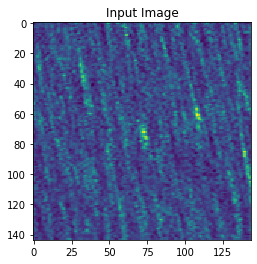

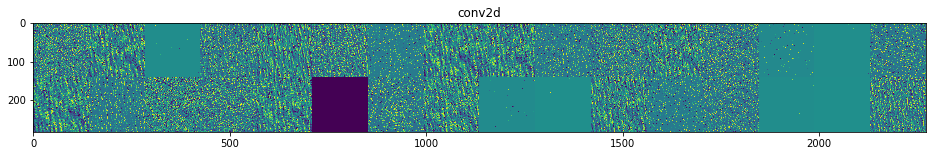

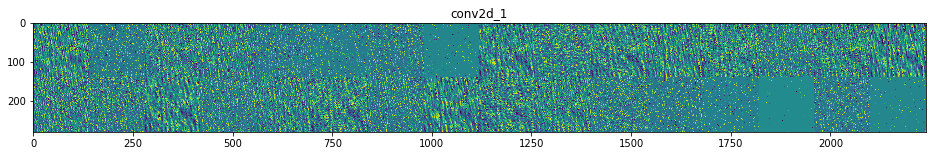

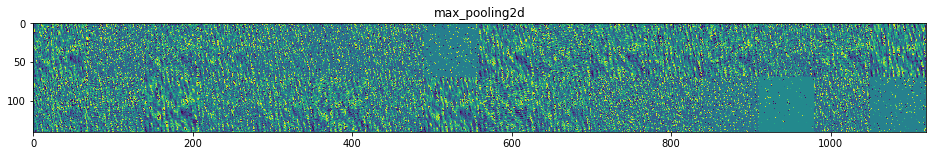

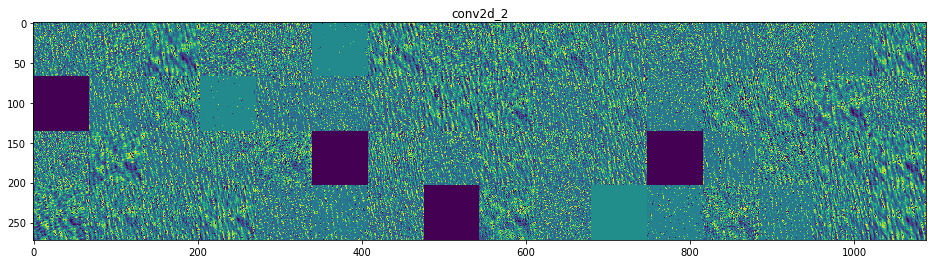

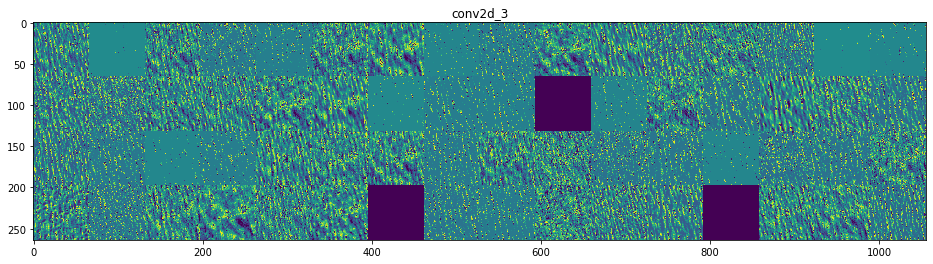

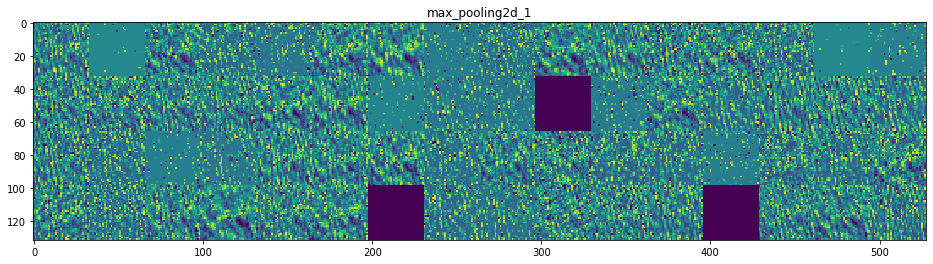

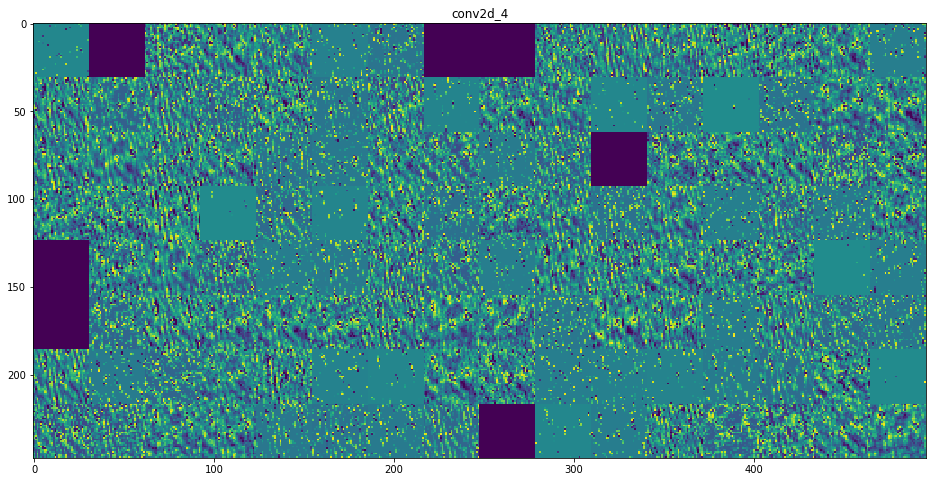

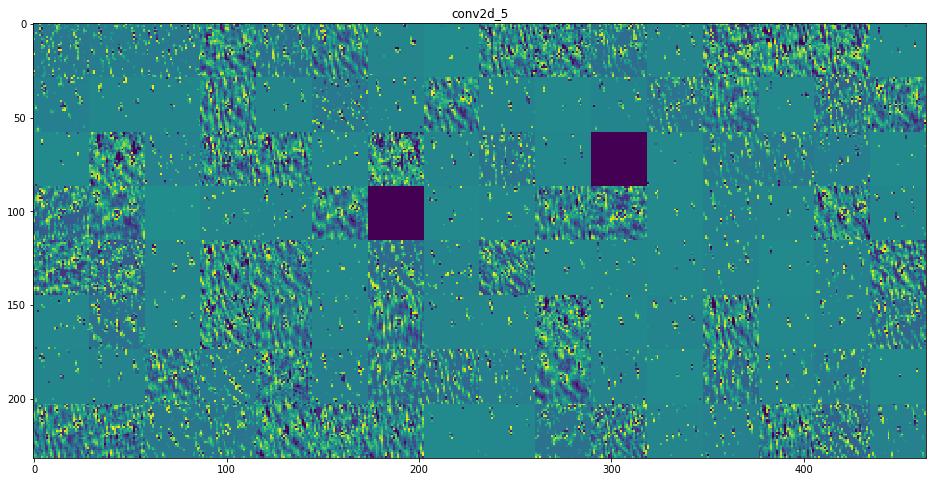

In [83]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np

#Load a trained convnet
from tensorflow.keras.models import load_model
model = load_model('VesselDetectorBest.h5')

model.summary()

#Dataset directories
vessel_dir = 'Chips/vessels'
nonvessel_dir = 'Chips/nonvessels'

#Get names of vessel data and nonvessel data files
from os import listdir
from os.path import isfile, join
vessel_files = [f for f in listdir(vessel_dir) if isfile(join(vessel_dir, f))]
nonvessel_files = [f for f in listdir(nonvessel_dir) if isfile(join(nonvessel_dir, f))]

num_rows, num_cols = 144, 144

#Get an input image—a vessel image, not part of the images the network was trained on
#(TODO), but preprocess it to be in the same format

image_id = 14
img_path = vessel_dir +"/"+ vessel_files[image_id] 
img = plt.imread(img_path)
x = image.img_to_array(img)#Converts image to a Numpy array with shape (144, 144, 1)
x = x.reshape(1,num_rows,num_cols,1)#Reshape it to (1, 144, 144, 1)

#Display the image
imgplot = plt.imshow(image.array_to_img(x[0]))
plt.title("Input Image")

#To extract the feature maps, create a Keras model that takes batches of images
#as input, and outputs the activations of all convolution and pooling layers.
#To do this, we use the Keras class Model. A model is instantiated using two
#arguments: an input tensor (or list of input tensors) and an output tensor
#(or list of output tensors).

from tensorflow.keras import models
N_top_layers = 8
layer_outputs = [layer.output for layer in model.layers[:N_top_layers]] #extract outputs of the N_top_layers top layers
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)#Creates a model that will return these outputs given the model input

#Running the model in predict mode
activations = activation_model.predict(x)#Returns a list of five Numpy arrays: one array per layer activation

#Plot every channel in every intermediate activation

#Get names of the layers
layer_names = []
for layer in model.layers[:N_top_layers]:
    layer_names.append(layer.name)
    
images_per_row = 16  

#Display the feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1] #Number of features in the feature map
    
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features)
    
    n_cols = n_features // images_per_row#Tile the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    
    #Tile each filter into a big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,:, :,col * images_per_row + row]
            #Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()#might produce warnings for a few filters
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 65535).astype('uint8')
            #Display the grid
            display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

Visualization -- TODO -- Grad-CAM ... Code below broken in TF2

In [5]:
import tensorflow
#from tensorflow.keras.preprocessing import image
import vis ## keras-vis
#from vis.utils import utils
import matplotlib.pyplot as plt
import numpy as np
#print("keras      {}".format(tf.keras.__version__))
#print("tensorflow {}".format(tf.__version__))

#Dataset directories
vessel_dir = 'Chips/vessels'
nonvessel_dir = 'Chips/nonvessels'

#Get names of vessel data and nonvessel data files
from os import listdir
from os.path import isfile, join
vessel_files = [f for f in listdir(vessel_dir) if isfile(join(vessel_dir, f))]
nonvessel_files = [f for f in listdir(nonvessel_dir) if isfile(join(nonvessel_dir, f))]

classlabel = ["Non-vessel", "Vessel"]

#from tensorflow.keras import models
model = models.load_model('VesselDetectorBest.h5')
model.summary()
for ilayer, layer in enumerate(model.layers):
    print("{:3.0f} {:10}".format(ilayer, layer.name))

image_id = 31
img_path = vessel_dir +"/"+ vessel_files[image_id] #augment vessel image image_id
#img = image.load_img(img_path, target_size=(144, 144))#read image & resize it
img = plt.imread(img_path)
x = image.img_to_array(img)#Converts it to a Numpy array with shape (144, 144, 1)
#x = x.reshape((1,) + x.shape)#Reshape it to (1, 144, 144, 1)
x = x.reshape(1,144,144,1)   
    
# #from tensorflow.keras import backend as K
# from scipy.ndimage.interpolation import zoom
# ## select class of interest
# class_idx           = 0
# ## feature map from the final convolusional layer
# final_fmap_index    = 10#utils.find_layer_idx(model, 'conv2d_7')
# penultimate_output  = model.layers[final_fmap_index].output

# ## define derivative d loss^c / d A^k,k =1,...,512
# layer_input          = model.input
# ## This model must already use linear activation for the final layer
# loss                 = model.layers[final_fmap_index].output[...,class_idx]#layer_idx
# grad_wrt_fmap        = K.gradients(loss,penultimate_output)[0]

# ## create function that evaluate the gradient for a given input
# # This function accept numpy array
# grad_wrt_fmap_fn     = K.function([layer_input,K.learning_phase()],
#                                   [penultimate_output,grad_wrt_fmap])

# ## evaluate the derivative_fn
# fmap_eval, grad_wrt_fmap_eval = grad_wrt_fmap_fn([img[np.newaxis,...],0])

# # For numerical stability. Very small grad values along with small penultimate_output_value can cause
# # w * penultimate_output_value to zero out, even for reasonable fp precision of float32.
# grad_wrt_fmap_eval /= (np.max(grad_wrt_fmap_eval) + K.epsilon())

# print(grad_wrt_fmap_eval.shape)
# alpha_k_c           = grad_wrt_fmap_eval.mean(axis=(0,1,2)).reshape((1,1,1,-1))
# Lc_Grad_CAM         = np.maximum(np.sum(fmap_eval*alpha_k_c,axis=-1),0).squeeze()

# ## upsampling the class activation map to th esize of ht input image
# scale_factor        = np.array(img.shape[:-1])/np.array(Lc_Grad_CAM.shape)
# _grad_CAM           = zoom(Lc_Grad_CAM,scale_factor)
# ## normalize to range between 0 and 1
# arr_min, arr_max    = np.min(_grad_CAM), np.max(_grad_CAM)
# grad_CAM            = (_grad_CAM - arr_min) / (arr_max - arr_min + K.epsilon())

# #Visualize 14 x 14  Lc_Grad_CAM
# plt.imshow(Lc_Grad_CAM)
# plt.show()

# #Visualize the a_k^c weights -- explains which feature map is most important for this class.
# plt.figure(figsize=(20,5))
# plt.plot(alpha_k_c.flatten())
# plt.xlabel("Feature Map at Final Convolusional Layer")
# plt.ylabel("alpha_k^c")
# plt.title("The {}th feature map has the largest weight alpha^k_c".format(
#     np.argmax(alpha_k_c.flatten())))
# plt.show()

#Using the keras-vis, visualize_activation(), we can visualize the image that
#maximize this most influential activation map. Does it make any sense??
from vis.visualization import visualize_activation
activation_max = visualize_activation(model, 
                                      layer_idx      = final_fmap_index, 
                                      max_iter       = 100,
                                      verbose        = True,
                                      filter_indices = 155)
print(activation_max.shape)
plt.imshow(activation_max)
plt.show()

AttributeError: module 'tensorflow_core.keras' has no attribute 'VERSION'